# Levenberg-Marquardt Optimization with AADC Derivatives
This notebook demonstrates using Levenberg-Marquardt optimization with both SciPy and the
AADC implementation.

## 1. Standard Implementation with SciPy
First, let's import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares

import aadc

%matplotlib inline
plt.ioff()  # Turn off interactive mode

Now we'll define our residual function:

In [2]:
# Define the function to be minimized (residuals)
def residual_func(params, x_data, y_data):
    # Example: fitting y = a * exp(-b * x) + c
    a, b, c = params
    y_model = a * np.exp(-b * x_data) + c
    return y_model - y_data

Let's generate some sample data for our optimization problem:

In [3]:
# Generate some sample data
np.random.seed(42)  # For reproducibility
x_data = np.linspace(0, 10, 10)
true_params = [5.0, 0.5, 1.0]
y_true = true_params[0] * np.exp(-true_params[1] * x_data) + true_params[2]
noise = np.random.normal(0, 0.2, x_data.shape)
y_data = y_true + noise
print("x_data:", x_data)
print("y_data:", y_data)

x_data: [ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
  6.66666667  7.77777778  8.88888889 10.        ]
y_data: [6.09934283 3.84111424 2.77550265 2.24898399 1.49500944 1.26405523
 1.49421253 1.25582732 0.96482327 1.14220174]


Now we'll create an optimization function:

True parameters: [5.0, 0.5, 1.0]
Optimal parameters: [4.97853755 0.49238319 1.08156689]
Cost: 0.09344010786115321
Success: True


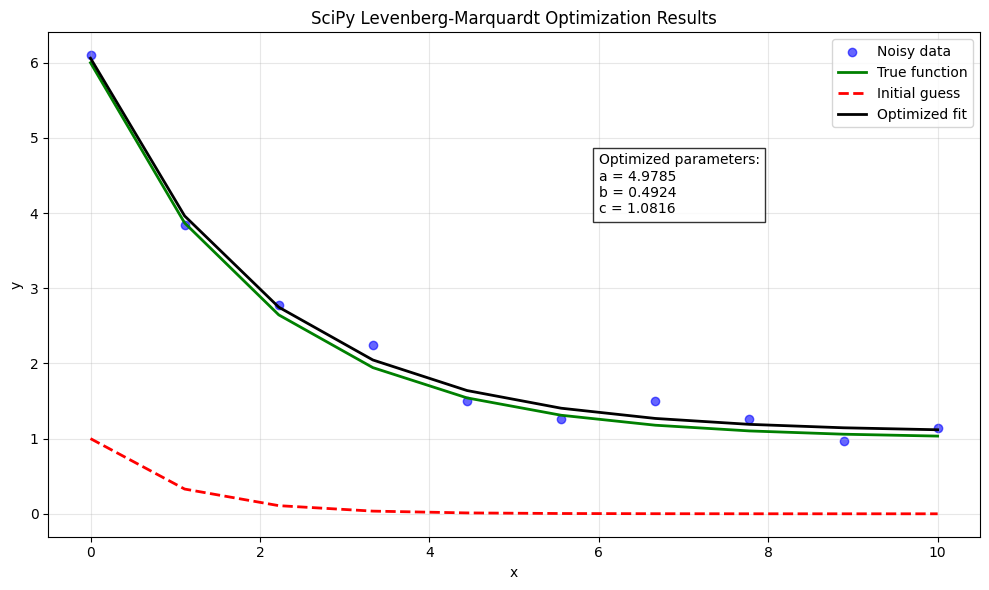

In [4]:
def run_optimization(x_data, y_data):
    # Initial guess for parameters
    initial_params = [1.0, 1.0, 0.0]

    # Perform Levenberg-Marquardt optimization
    result = least_squares(
        residual_func,
        initial_params,
        method='lm',
        args=(x_data, y_data),
        verbose=0
    )

    return result, initial_params

# Run the optimization
result, initial_params = run_optimization(x_data, y_data)

# Print results
print("True parameters:", true_params)
print("Optimal parameters:", result.x)
print("Cost:", result.cost)
print("Success:", result.success)

# Plot the optimization results for SciPy implementation
plt.figure(figsize=(10, 6))

# Plot the noisy data points
plt.scatter(x_data, y_data, color='blue', alpha=0.6, label='Noisy data')

# Plot the true function
plt.plot(x_data, y_true, 'g-', linewidth=2, label='True function')

# Plot the initial guess
initial_guess = initial_params[0] * np.exp(-initial_params[1] * x_data) + initial_params[2]
plt.plot(x_data, initial_guess, 'r--', linewidth=2, label='Initial guess')

# Plot the optimized function
a_opt, b_opt, c_opt = result.x
y_opt = a_opt * np.exp(-b_opt * x_data) + c_opt
plt.plot(x_data, y_opt, 'k-', linewidth=2, label='Optimized fit')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('SciPy Levenberg-Marquardt Optimization Results')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text box with optimized parameters
param_text = f'Optimized parameters:\na = {a_opt:.4f}\nb = {b_opt:.4f}\nc = {c_opt:.4f}'
plt.text(6, 4, param_text, bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

## 2. Implementation with AADC
Note that objective function is using y_data internally and derivatives must be calculated with
respect to y_data. AADC.least_squares() function doesn't require Jacobian w.r.t. y_data, it will
be calculated automatically. See Automatic IFT publication for more details.

In [5]:
# AADC version

func = aadc.Kernel()
func.start_recording()

# Define the residual function with AADC inputs
iy_data = aadc.ndarray.AADCArray([aadc.idouble(y) for y in y_data])
iy_data_arg = [y.mark_as_input() for y in iy_data]

def objective(params):
    return residual_func(params, x_data, iy_data)

aadc_result = aadc.least_squares(objective, initial_params)
print("AADC Optimal parameters:", aadc_result.x)

x_res = [a.mark_as_output() for a in aadc_result.x]
func.stop_recording()
func.print_passive_extract_locations()

inputs = {y_arg: y for y_arg, y in zip(iy_data_arg, y_data)}
request = {x_res[i]: iy_data_arg for i in range(len(x_res))}
res = aadc.evaluate(func, request, inputs)

print("True parameters:", true_params)
print("Scipy Optimal parameters:", result.x)
print("AADC Kernel Optimal parameters:", [res[0][x_res[i]] for i in range(len(x_res))])

AADC Optimal parameters: [idouble([AAD[rv] [adj] :49,4.98e+00]), idouble([AAD[rv] [adj] :48,4.92e-01]), idouble([AAD[rv] [adj] :47,1.08e+00])]
True parameters: [5.0, 0.5, 1.0]
Scipy Optimal parameters: [4.97853755 0.49238319 1.08156689]
AADC Kernel Optimal parameters: [array([4.97853756]), array([0.49238342]), array([1.08156727])]
Number active to passive conversions: 0 while recording Python


## 3. Comparing Derivatives
Let's compare the derivatives computed by both methods:

In [6]:
print("AADC Kernel Derivatives param 0:", res[1][x_res[0]])
print("AADC Kernel Derivatives param 1:", res[1][x_res[1]])
print("AADC Kernel Derivatives param 2:", res[1][x_res[2]])

AADC Kernel Derivatives param 0: {Arg(6): array([0.81683395]), Arg(7): array([0.3554679]), Arg(8): array([0.09492761]), Arg(9): array([-0.05211405]), Arg(10): array([-0.13504729]), Arg(11): array([-0.18179121]), Arg(12): array([-0.20811897]), Arg(13): array([-0.22293658]), Arg(14): array([-0.23126954]), Arg(15): array([-0.23595182])}
AADC Kernel Derivatives param 1: {Arg(6): array([0.11174537]), Arg(7): array([-0.08914377]), Arg(8): array([-0.12158058]), Arg(9): array([-0.09185823]), Arg(10): array([-0.04660153]), Arg(11): array([-0.00417919]), Arg(12): array([0.02976195]), Arg(13): array([0.05483713]), Arg(14): array([0.0724917]), Arg(15): array([0.08452715])}
AADC Kernel Derivatives param 2: {Arg(6): array([0.10139151]), Arg(7): array([-0.13910781]), Arg(8): array([-0.13397366]), Arg(9): array([-0.04750999]), Arg(10): array([0.05083191]), Arg(11): array([0.13568989]), Arg(12): array([0.2009665]), Arg(13): array([0.24809697]), Arg(14): array([0.28078374]), Arg(15): array([0.30283094])

Now let's verify the derivatives using the finite difference method:

In [7]:
# Define the function to calculate derivatives using finite differences
def calculate_finite_diff_derivatives(params, x_data, y_data, epsilon=1e-6):
    derivatives = []

    for i in range(len(params)):
        param_derivatives = []

        for j in range(len(y_data)):
            # Create modified y_data with a bump in one element
            y_bumped = y_data.copy()
            y_bumped[j] += epsilon

            # Run optimization with bumped data
            bumped_result, _ = run_optimization(x_data, y_bumped)

            # Calculate derivative (change in parameter / change in y)
            derivative = (bumped_result.x[i] - params[i]) / epsilon
            param_derivatives.append(derivative)

        derivatives.append(param_derivatives)

    return derivatives

# Calculate finite difference derivatives for all parameters
# Use %%capture to suppress the output
print("Calculating finite difference derivatives (this may take some time)...")
fd_derivatives = calculate_finite_diff_derivatives(result.x, x_data, y_data)

# Extract AADC derivatives in a format suitable for comparison
aadc_derivatives = []
for i in range(len(result.x)):
    # Extract derivatives from the AADC result
    aadc_deriv_i = np.array([res[1][x_res[i]][y_arg][0] for y_arg in iy_data_arg])
    aadc_derivatives.append(aadc_deriv_i)

    print(f"Parameter {i} derivatives:")
    print(f" AADC: {aadc_deriv_i}")
    print(f" Finite diff: {fd_derivatives[i]}")
    print(f" Mean difference: {np.mean(np.abs(aadc_deriv_i - np.array(fd_derivatives[i])))}")
    print()

Calculating finite difference derivatives (this may take some time)...
Parameter 0 derivatives:
 AADC: [ 0.81683395  0.3554679   0.09492761 -0.05211405 -0.13504729 -0.18179121
 -0.20811897 -0.22293658 -0.23126954 -0.23595182]
 Finite diff: [0.8178400756619908, 0.35544883747462563, 0.0940900886092777, -0.05154101856419402, -0.13586673919263603, -0.1827945004251319, -0.20837273773111065, -0.2246153014695551, -0.22932849752521633, -0.23545129135271736]
 Mean difference: 0.0008632547095553007

Parameter 1 derivatives:
 AADC: [ 0.11174537 -0.08914377 -0.12158058 -0.09185823 -0.04660153 -0.00417919
  0.02976195  0.05483713  0.0724917   0.08452715]
 Finite diff: [0.1132547177706833, -0.09221475133491808, -0.12401560911534659, -0.09511606507972559, -0.04909219042392721, -0.006147247599841421, 0.030859840127739346, 0.05348991372056133, 0.07389429901305533, 0.08634244647032219]
 Mean difference: 0.0020394909519541025

Parameter 2 derivatives:
 AADC: [ 0.10139151 -0.13910781 -0.13397366 -0.047509

## 4. Combined Visualization
Let's visualize both the optimization results and parameter sensitivities in a single figure:

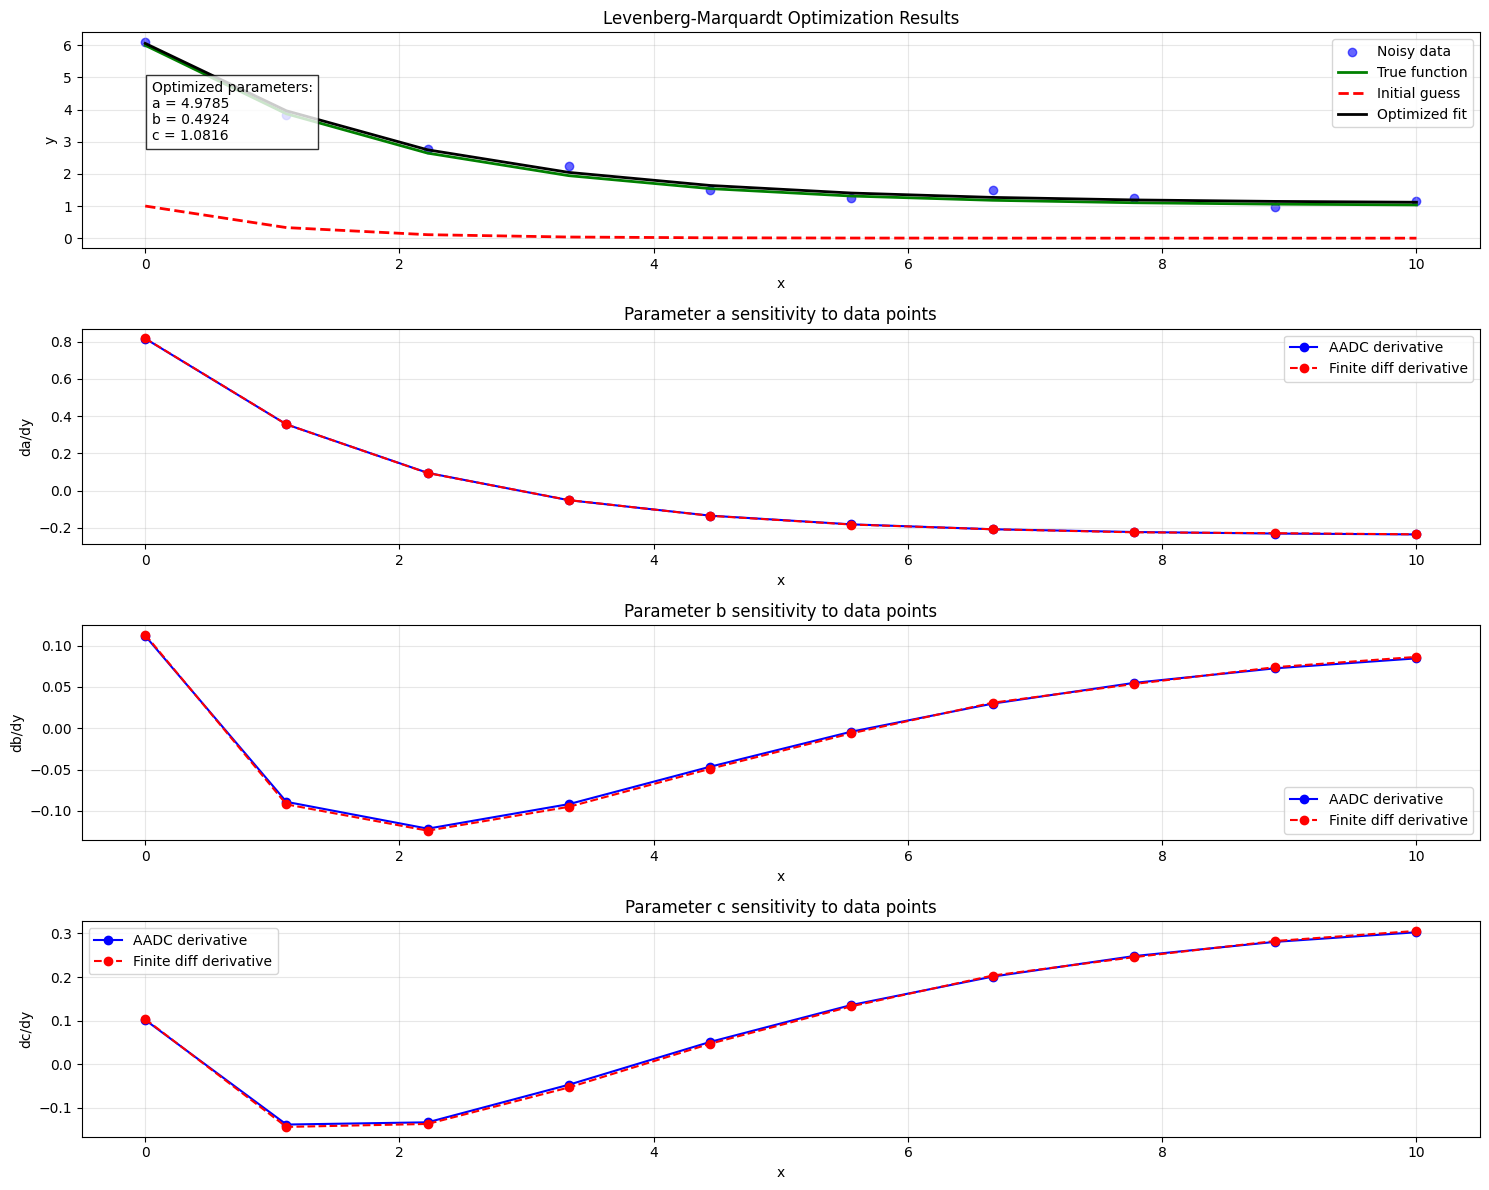

In [8]:
# Create a combined figure with optimization results and parameter sensitivities
fig = plt.figure(figsize=(15, 12))

# Plot 1: Optimization Results (Top)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=1)

# Plot the noisy data points
ax1.scatter(x_data, y_data, color='blue', alpha=0.6, label='Noisy data')

# Plot the true function
ax1.plot(x_data, y_true, 'g-', linewidth=2, label='True function')

# Plot the initial guess
initial_guess = initial_params[0] * np.exp(-initial_params[1] * x_data) + initial_params[2]
ax1.plot(x_data, initial_guess, 'r--', linewidth=2, label='Initial guess')

# Plot the optimized function
a_opt, b_opt, c_opt = result.x
y_opt = a_opt * np.exp(-b_opt * x_data) + c_opt
ax1.plot(x_data, y_opt, 'k-', linewidth=2, label='Optimized fit')

# Add labels and legend
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Levenberg-Marquardt Optimization Results')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Add text box with optimized parameters
param_text = f'Optimized parameters:\na = {a_opt:.4f}\nb = {b_opt:.4f}\nc = {c_opt:.4f}'
ax1.text(0.05, 0.5, param_text, transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

# Plots 2-4: Parameter Sensitivities (Bottom three rows)
param_names = ['a', 'b', 'c']
for i in range(len(result.x)):
    ax = plt.subplot2grid((4, 1), (i+1, 0), rowspan=1)

    ax.plot(x_data, aadc_derivatives[i], 'bo-', label='AADC derivative')
    ax.plot(x_data, fd_derivatives[i], 'ro--', label='Finite diff derivative')

    ax.set_title(f'Parameter {param_names[i]} sensitivity to data points')
    ax.set_xlabel('x')
    ax.set_ylabel(f'd{param_names[i]}/dy')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Automatic Implicit Function Theorem - Summary

## Paper Details

* Title: Automatic Implicit Function Theorem
* Authors: Dmitri Goloubentsev, Evgeny Lakshtanov, Vladimir Piterbarg
* Affiliation: Matlogica, Universidade de Aveiro, NatWest Markets, Imperial College London
* Published: December 14, 2021 (Revised: May 31, 2022)
* SSRN ID: 3984964
* URL: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3984964